# This workbook demonstrates how to investigate the effect of uncertainty on calculated temperatures for liquid-only thermometers

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
import Thermobar as pt
pd.options.display.max_columns = None

## This sets plotting parameters

In [2]:
# This sets some plotting things
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

#  Example 1: Absolute errors in wt%
- input spreadsheet has absolute errors (in wt%) as column headings (e.g., from experimental studies where they report 1 sigma uncertainties)
- We want to generate N synthetic liquids for each real liquid whose parameters vary within these error bounds. 

In [3]:
# this cell loads the data, e.g., colum headings SiO2_Liq, MgO_Liq etc. 
out=pt.import_excel('Liquid_Errors.xlsx', sheet_name="Error_Example_Abs")
my_input=out['my_input']
myLiquids1=out['Liqs']

In [4]:
# This cell loads the errors, reading from columns SiO2_Liq_Err, MgO_Liq_Err etc. 
out_Err=pt.import_excel_errors('Liquid_Errors.xlsx', sheet_name="Error_Example_Abs")
myLiquids1_Err=out_Err['Liqs_Err']
myinput_Out=out_Err['my_input_Err']

In [5]:
display(myLiquids1_Err.head())
display(myLiquids1.head())

,SiO2_Liq_Err,TiO2_Liq_Err,Al2O3_Liq_Err,FeOt_Liq_Err,MnO_Liq_Err,MgO_Liq_Err,CaO_Liq_Err,Na2O_Liq_Err,K2O_Liq_Err,Cr2O3_Liq_Err,P2O5_Liq_Err,H2O_Liq_Err,Fe3FeT_Liq_Err,NiO_Liq_Err,CoO_Liq_Err,CO2_Liq_Err,Sample_ID_Liq_Err,P_kbar_Err,T_K_Err
0,0.168800,0.094674,0.352282,0.185453,0.003443,0.423718,0.185089,0.424152,0.273896,0.007649,0.011024,0.2,0.0,0.0,0.0,0.0,0,0.1,5
1,0.273773,0.043005,0.128686,0.348039,0.062106,0.422937,0.427487,0.255009,0.455046,0.005722,0.032563,0.2,0.0,0.0,0.0,0.0,1,0.1,5
2,0.216526,0.045624,0.037117,0.368804,0.097813,0.007730,0.458202,0.160674,0.332565,0.002960,0.006635,0.2,0.0,0.0,0.0,0.0,2,0.1,5
3,0.984937,0.008604,0.125205,0.330998,0.065548,0.393717,0.369659,0.055583,0.194877,0.003742,0.001138,0.2,0.0,0.0,0.0,0.0,3,0.1,5
4,0.661858,0.053289,0.408826,0.153988,0.063849,0.192904,0.463465,0.117601,0.316096,0.006090,0.021499,0.2,0.0,0.0,0.0,0.0,4,0.1,5


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq,P_kbar,T_K
0,57.023602,0.623106,16.332899,4.36174,0.103851,4.19180,6.94858,3.59702,0.896895,0.000000,0.226584,5.59,0.2,0.0,0.0,0.0,0,2.0,1313.15
1,57.658600,0.654150,17.194799,3.90621,0.084105,2.86892,5.91538,3.85948,1.018600,0.000000,0.214935,6.55,0.2,0.0,0.0,0.0,1,2.0,1293.15
2,60.731201,0.862054,17.144199,4.07781,0.077488,2.50867,5.22075,4.45556,1.414160,0.000000,0.319638,3.14,0.2,0.0,0.0,0.0,2,2.0,1253.15
3,61.532799,0.440860,16.508801,3.32990,0.037520,1.64150,4.34294,4.40860,1.407000,0.000000,0.215740,6.20,0.2,0.0,0.0,0.0,3,2.0,1213.15
4,52.969101,0.803412,17.563000,5.93217,0.149472,3.78351,7.65110,3.80219,0.551178,0.037368,0.196182,6.58,0.2,0.0,0.0,0.0,4,2.0,1303.15


## Use function add_noise_sample_1phase() to add sample noise and make lots of synthetic liquids
- adds noise to myLiquids1 from a normal distribution with a mean defined by the measured value of each element, and the user-entered 1 sigma value
- Specify number of re-samples per liquid using "duplicates". e.g., here, make 1000 synthetic liquids per liquid
- By default all negative numbers are replaced with zeros, but you can set Positive=False if you don't want this behavoir

In [6]:
Liquids_only_abs_noise=pt.add_noise_sample_1phase(phase_comp=myLiquids1, phase_err=myLiquids1_Err,
                                             phase_err_type="Abs", duplicates=1000, err_dist="normal")


All negative numbers replaced with zeros. If you wish to keep these, set positive=False


In [8]:
Liquids_only_abs_noise

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,P_kbar,T_K,Sample_ID_Liq_Num
0,56.796604,0.757061,16.709191,4.553603,0.106345,3.545455,6.865206,3.579678,0.554322,0.005422,0.222779,5.953019,0.0,0.0,0.0,0.0,2.038574,1318.540341,0.0
1,56.935934,0.647278,16.228090,4.496217,0.109481,4.476272,6.562752,3.067974,0.910511,0.000000,0.240226,5.539313,0.0,0.0,0.0,0.0,2.040353,1318.293685,0.0
2,57.209674,0.599760,16.004122,4.592534,0.106099,3.966230,6.972442,3.459890,0.771151,0.002428,0.207002,5.851809,0.0,0.0,0.0,0.0,1.975016,1311.487890,0.0
3,57.002973,0.600221,15.975949,4.083245,0.107008,4.611743,6.773581,3.332144,0.814947,0.000000,0.230439,5.344882,0.0,0.0,0.0,0.0,1.779829,1311.136920,0.0
4,57.239663,0.590972,15.666256,4.243757,0.105667,4.450227,7.114587,3.559755,0.663471,0.006386,0.219801,5.712070,0.0,0.0,0.0,0.0,1.982094,1310.381583,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,50.588983,0.575156,18.384033,5.940487,0.085561,5.091656,10.073364,3.157952,0.379166,0.009832,0.001926,5.305605,0.0,0.0,0.0,0.0,1.885441,1358.559750,9.0
9996,51.118219,0.711112,18.010566,6.100601,0.222708,5.172576,9.792885,3.070296,0.493267,0.001603,0.005092,5.217469,0.0,0.0,0.0,0.0,2.046890,1360.022108,9.0
9997,51.825088,0.507091,18.220590,5.736179,0.138140,5.843241,9.848129,3.194390,0.710739,0.010014,0.000000,4.893573,0.0,0.0,0.0,0.0,2.114020,1360.241249,9.0
9998,51.444721,0.523634,18.290492,5.823063,0.000000,5.321126,9.632558,3.075492,0.584083,0.014805,0.000000,4.951536,0.0,0.0,0.0,0.0,1.956623,1370.378256,9.0


- Here, we can look at all 1000 of the synthetic liquids generated for the first user-entered liquid 

In [9]:
# This is saying get me rows where the sample ID=0
Liquids_only_abs_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==0]

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,P_kbar,T_K,Sample_ID_Liq_Num
0,56.796604,0.757061,16.709191,4.553603,0.106345,3.545455,6.865206,3.579678,0.554322,0.005422,0.222779,5.953019,0.0,0.0,0.0,0.0,2.038574,1318.540341,0.0
1,56.935934,0.647278,16.228090,4.496217,0.109481,4.476272,6.562752,3.067974,0.910511,0.000000,0.240226,5.539313,0.0,0.0,0.0,0.0,2.040353,1318.293685,0.0
2,57.209674,0.599760,16.004122,4.592534,0.106099,3.966230,6.972442,3.459890,0.771151,0.002428,0.207002,5.851809,0.0,0.0,0.0,0.0,1.975016,1311.487890,0.0
3,57.002973,0.600221,15.975949,4.083245,0.107008,4.611743,6.773581,3.332144,0.814947,0.000000,0.230439,5.344882,0.0,0.0,0.0,0.0,1.779829,1311.136920,0.0
4,57.239663,0.590972,15.666256,4.243757,0.105667,4.450227,7.114587,3.559755,0.663471,0.006386,0.219801,5.712070,0.0,0.0,0.0,0.0,1.982094,1310.381583,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,56.688577,0.591735,16.618541,3.963912,0.107990,3.817037,7.120460,3.902299,1.130166,0.006572,0.231534,5.673122,0.0,0.0,0.0,0.0,2.095236,1312.719950,0.0
996,57.033363,0.677592,16.005518,4.589758,0.103558,4.919321,6.666011,3.026727,0.682875,0.000000,0.218529,5.668799,0.0,0.0,0.0,0.0,2.132686,1309.890313,0.0
997,57.187479,0.532156,16.283709,4.393675,0.108309,4.662938,6.753409,3.716505,0.977467,0.000000,0.240350,5.882177,0.0,0.0,0.0,0.0,2.032297,1316.367709,0.0
998,57.329117,0.616745,16.252004,4.615157,0.094808,4.287730,6.608413,3.541096,1.114214,0.000000,0.224792,5.497011,0.0,0.0,0.0,0.0,1.923040,1314.820030,0.0


- We can plot some elements up against the user-entered 1 sigma

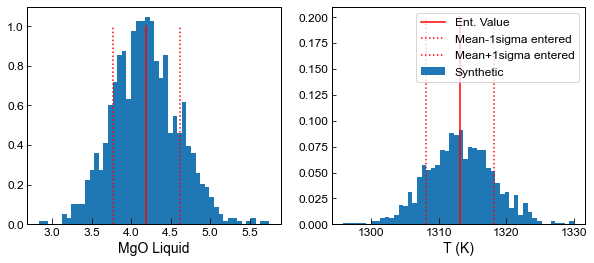

In [10]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(Liquids_only_abs_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==0, 'MgO_Liq'], bins=50, label='Synthetic', density=True)  ;
ax1.plot([myLiquids1['MgO_Liq'].iloc[0], myLiquids1['MgO_Liq'].iloc[0]], [0, 1], '-r', label='Ent. Value')
ax1.plot([myLiquids1['MgO_Liq'].iloc[0]-myLiquids1_Err['MgO_Liq_Err'].iloc[0], 
          myLiquids1['MgO_Liq'].iloc[0]-myLiquids1_Err['MgO_Liq_Err'].iloc[0]], 
         [0, 1], ':r', label='Mean-1sigma entered')
ax1.plot([myLiquids1['MgO_Liq'].iloc[0]+myLiquids1_Err['MgO_Liq_Err'].iloc[0], 
          myLiquids1['MgO_Liq'].iloc[0]+myLiquids1_Err['MgO_Liq_Err'].iloc[0]], 
         [0, 1], ':r', label='Mean+1sigma entered')
ax1.set_xlabel('MgO Liquid')

ax2.hist(Liquids_only_abs_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==0, 'T_K'], bins=50, label='Synthetic', density=True) ;
ax2.plot([myLiquids1['T_K'].iloc[0], myLiquids1['T_K'].iloc[0]], [0, 0.2], '-r', label='Ent. Value')
ax2.plot([myLiquids1['T_K'].iloc[0]-myLiquids1_Err['T_K_Err'].iloc[0], 
          myLiquids1['T_K'].iloc[0]-myLiquids1_Err['T_K_Err'].iloc[0]], 
         [0, 0.2], ':r', label='Mean-1sigma entered')
ax2.plot([myLiquids1['T_K'].iloc[0]+myLiquids1_Err['T_K_Err'].iloc[0], 
          myLiquids1['T_K'].iloc[0]+myLiquids1_Err['T_K_Err'].iloc[0]], 
         [0, 0.2], ':r', label='Mean+1sigma entered')
ax2.set_xlabel('T (K)')
ax2.legend()

## Now, input this synthetic dataframe into the functions for calculating temperature
- Here, using equation 22 of Putirka (2008), where DMg ol-liq is calculated theoretically using DMg from Beattie (1993) so this can be used as an olivine-only thermometer

In [11]:
T_noise=pt.calculate_liq_only_temp(liq_comps=Liquids_only_abs_noise, equationT="T_Put2008_eq22_BeattDMg", P=Liquids_only_abs_noise['P_kbar'])


### In this plot we show the histogram for the temperature from each liquid for liquid 1, 2, 3, and 4 (for all 1000 liquids generated from it)
- All synthetic liquids generated from a single input liquid have the same value of 'Sample_ID_Liq_Num'

Text(0, 0.5, 'Probability Density')

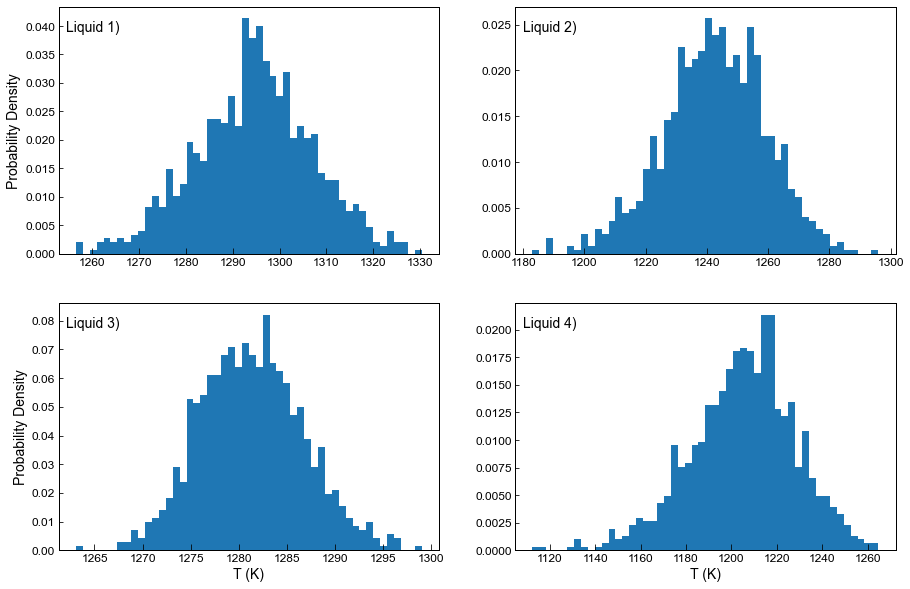

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.annotate("Liquid 1)", xy=(0.02, 0.9), xycoords="axes fraction", fontsize=14)
ax1.hist(T_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==0], bins=50, density=True);
ax2.annotate("Liquid 2)", xy=(0.02, 0.9), xycoords="axes fraction", fontsize=14)
ax2.hist(T_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==1], bins=50, density=True);
ax3.annotate("Liquid 3)", xy=(0.02, 0.9), xycoords="axes fraction", fontsize=14)
ax3.hist(T_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==2], bins=50, density=True);
ax4.annotate("Liquid 4)", xy=(0.02, 0.9), xycoords="axes fraction", fontsize=14)
ax4.hist(T_noise.loc[Liquids_only_abs_noise['Sample_ID_Liq_Num']==3], bins=50, density=True);
ax4.set_xlabel('T (K)')
ax3.set_xlabel('T (K)')
ax1.set_ylabel('Probability Density')
ax3.set_ylabel('Probability Density')

### We can also use a function to get the mean, median and standard deviation for each liquid
- The two arguements for this function are 1) The panda series you want to average (in this case, temperature)
- The panda series of values you want to average by, e.g., here averaging all samples with the same sample ID.

In [43]:
Stats_T_K=pt.av_noise_samples_series(T_noise, Liquids_only_abs_noise['Sample_ID_Liq_Num'])
Stats_T_K

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1294.579611,1294.909302,12.467986,1330.331815,1256.530952
1,1.0,1242.429926,1242.609916,16.811657,1296.001343,1183.053751
2,2.0,1281.346255,1281.277801,5.325644,1299.031301,1263.063686
3,3.0,1205.130647,1206.469540,22.927686,1264.676970,1112.344980
4,4.0,1267.401054,1267.318798,7.221805,1291.088143,1246.232403
5,5.0,1253.803113,1253.765029,3.349819,1264.196091,1242.848022
6,6.0,1244.227457,1244.293953,5.493144,1260.804244,1225.596966
7,7.0,1212.016731,1211.830624,4.047529,1226.981909,1200.178010
8,8.0,1181.672126,1181.838334,6.984812,1201.903761,1152.069038
9,9.0,1319.560347,1320.204183,9.047673,1350.565325,1289.071594


# Example 2 - Percentage Errors
- Here, in the input spreadsheet we have specified a percentage error for each input (e.g., you could estimate this from EPMA analyses of secondary standards)

In [44]:
out2=pt.import_excel('Liquid_Errors.xlsx', sheet_name="Error_Example_Perc")
my_input2=out2['my_input']
myOls2=out2['Ols']
myLiquids2=out2['Liqs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
out_Err2=pt.import_excel_errors('Liquid_Errors.xlsx', sheet_name="Error_Example_Perc")
myLiquids2_Err=out_Err2['Liqs_Err']
myinput2_Out=out_Err2['my_input_Err']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
display(myLiquids2_Err.head())

,SiO2_Liq_Err,TiO2_Liq_Err,Al2O3_Liq_Err,FeOt_Liq_Err,MnO_Liq_Err,MgO_Liq_Err,CaO_Liq_Err,Na2O_Liq_Err,K2O_Liq_Err,Cr2O3_Liq_Err,P2O5_Liq_Err,H2O_Liq_Err,Fe3FeT_Liq_Err,NiO_Liq_Err,CoO_Liq_Err,CO2_Liq_Err,Sample_ID_Liq_Err,P_kbar_Err,T_K_Err
0,1,3,5,4,10,2,3,10,10,20,5,10,0.0,0.0,0.0,0.0,0,1,1
1,1,3,5,4,10,2,3,10,10,20,5,10,0.0,0.0,0.0,0.0,1,1,1
2,1,3,5,4,10,2,3,10,10,20,5,10,0.0,0.0,0.0,0.0,2,1,1
3,1,3,5,4,10,2,3,10,10,20,5,10,0.0,0.0,0.0,0.0,3,1,1
4,1,3,5,4,10,2,3,10,10,20,5,10,0.0,0.0,0.0,0.0,4,1,1


### This function add errors based on the dataframe Liquid2_Err which are percentage errors. 
- makes 1000 liquids per user-entered row, and assume errors are normally distributed
- Here, say Positive=False, which means it keeps negative numbers

In [47]:
Liquids_only_noise2=pt.add_noise_sample_1phase(phase_comp=myLiquids2, phase_err=myLiquids2_Err,
                                             phase_err_type="Perc", duplicates=1000, err_dist="normal", positive=False)


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Validation that its calculating percentage errors right, as told it to add 1% error for SiO2. This will vary a bit as you run it, as its random
Mean=np.mean(Liquids_only_noise2.loc[Liquids_only_noise2['Sample_ID_Liq_Num']==0, 'SiO2_Liq'])
std_Dev=np.nanstd(Liquids_only_noise2.loc[Liquids_only_noise2['Sample_ID_Liq_Num']==0, 'SiO2_Liq'])
100*std_Dev/Mean

1.0402033943571478

## Calculating temperatures for all these synthetic liquids using equation 16 of Putirka (2008)

In [49]:
T_noise2=pt.calculate_liq_only_temp(liq_comps=Liquids_only_noise2, equationT="T_Put2008_eq16", P=Liquids_only_noise2['P_kbar'])

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Calculating standard deviations, means, and medians etc

In [50]:
Stats_T_K2=pt.av_noise_samples_series(T_noise2, Liquids_only_noise2['Sample_ID_Liq_Num'])
Stats_T_K2

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1338.824514,1337.991022,21.329338,1411.784584,1269.253655
1,1.0,1262.528343,1261.251650,26.176866,1342.798831,1180.833556
2,2.0,1268.488239,1267.693551,27.423224,1377.537237,1177.070414
3,3.0,1240.041943,1239.030164,32.056650,1361.212216,1152.788001
4,4.0,1304.762300,1304.561600,16.613132,1357.944427,1249.961731
5,5.0,1287.881233,1287.471398,20.105576,1358.869061,1227.467649
6,6.0,1269.249977,1269.107983,22.382743,1354.168175,1189.642621
7,7.0,1399.793159,1398.903775,18.697020,1468.685671,1346.327485
8,8.0,1303.699377,1303.224023,21.249742,1370.191248,1241.879856
9,9.0,1358.426294,1357.857729,11.633523,1395.415793,1322.138937


# Example 3: Fixed Percentage Error
- Here, instead of inputted columns with "_Err" for each oxide, we just add a fixed percentage error to all oxides (still normally distributed) - here, 1% noise

In [22]:
out3=pt.import_excel('Liquid_Errors.xlsx', sheet_name="Error_Example_Perc")
my_input3=out3['my_input']
myOls23=out3['Ols']
myLiquids3=out3['Liqs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
Liquids_only_noise3=pt.add_noise_sample_1phase(phase_comp=myLiquids3, duplicates=1000,
                           noise_percent=1, err_dist="normal")

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
T_noise3=pt.calculate_liq_only_temp(liq_comps=Liquids_only_noise3, equationT="T_Put2008_eq16", P=Liquids_only_noise3['P_kbar'])

In [25]:
Stats_T_K3=pt.av_noise_samples_series(T_noise3, Liquids_only_noise3['Sample_ID_Liq_Num'])
Stats_T_K3

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1337.679917,1337.609694,4.782627,1355.016093,1321.355396
1,1.0,1260.395403,1260.345324,5.629103,1279.695410,1244.383126
2,2.0,1265.779095,1265.684930,5.990361,1285.565084,1247.975159
3,3.0,1239.315167,1239.364520,7.579441,1265.551799,1217.094470
4,4.0,1303.863894,1303.775358,3.610240,1315.009882,1289.148256
5,5.0,1287.185386,1286.911550,4.014969,1303.378448,1275.571057
6,6.0,1268.539494,1268.420080,4.821531,1289.165561,1252.919780
7,7.0,1399.235961,1399.147017,4.062297,1412.063666,1388.751132
8,8.0,1302.890895,1302.885245,4.586855,1316.454203,1290.941321
9,9.0,1357.808700,1357.783081,2.903494,1367.187199,1347.297309


# Example 4: Perc uncertainty in a single input parameter
- Here, want to add 5% error to MgO in the liquid. You don't have to specify _Liq, it adds this based on what you entered. 

In [26]:
Liquids_only_noise4=pt.add_noise_sample_1phase(phase_comp=myLiquids1, variable="MgO", variable_err=5, 
                                              variable_err_type="Perc", duplicates=1000, err_dist="normal")


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
T_noise4=pt.calculate_liq_only_temp(liq_comps=Liquids_only_noise4, equationT="T_Put2008_eq16", P=Liquids_only_noise4['P_kbar'])

In [28]:
Stats_T_K4=pt.av_noise_samples_series(T_noise4, Liquids_only_noise4['Sample_ID_Liq_Num'])
Stats_T_K4

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1337.349121,1337.421100,7.010723,1358.242296,1311.502817
1,1.0,1260.603918,1260.600760,5.262711,1275.800303,1241.037201
2,2.0,1266.134132,1266.033566,4.544166,1281.057129,1250.920261
3,3.0,1239.306030,1239.358724,3.257498,1251.953585,1228.936603
4,4.0,1303.641367,1303.640070,6.635795,1323.397723,1281.857313
5,5.0,1287.153118,1287.250255,5.755645,1307.942305,1267.194498
6,6.0,1268.385253,1268.304531,4.907016,1287.653566,1255.120511
7,7.0,1399.279818,1399.318547,7.523701,1424.807441,1378.442271
8,8.0,1303.126289,1303.023877,6.804293,1324.384227,1282.552805
9,9.0,1357.337230,1357.509424,7.937476,1380.782185,1333.893108


# Example 5: Absolute uncertainty in a given input parameter
- Here, say uncertainty in H2O content of the liquid is 1 wt%

In [29]:
Liquids_only_noise5=pt.add_noise_sample_1phase(phase_comp=myLiquids1, variable="H2O", variable_err=1, 
                                              variable_err_type="Abs", duplicates=1000, err_dist="normal")


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### plot a histogram of resulting H2O distribution

Text(0, 0.5, 'Probability Density')

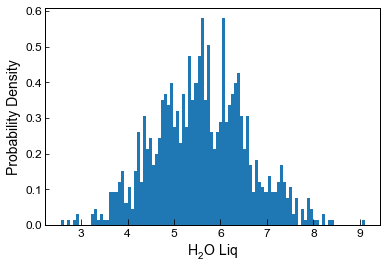

In [30]:
plt.hist(Liquids_only_noise5.loc[Liquids_only_noise4['Sample_ID_Liq_Num']==0, 'H2O_Liq'], bins=100, density= True);
plt.xlabel('H$_2$O Liq')
plt.ylabel('Probability Density')

### Now feed this into a thermometer

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'T (K)')

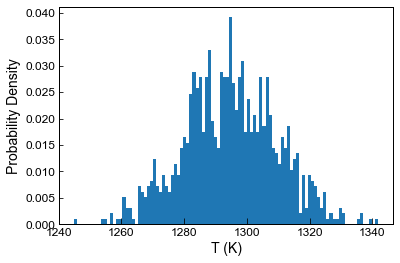

In [31]:
#Feed into a thermometer
T_noise5=pt.calculate_liq_only_temp(liq_comps=Liquids_only_noise5, equationT="T_Put2008_eq22_BeattDMg", 
                              P=Liquids_only_noise5['P_kbar'])
plt.hist(T_noise5.loc[Liquids_only_noise5['Sample_ID_Liq_Num']==0], bins=100, density=True);
plt.ylabel('Probability Density')
plt.xlabel('T (K)')

In [32]:
Stats_T_K5=pt.av_noise_samples_series(T_noise5, Liquids_only_noise5['Sample_ID_Liq_Num'])
Stats_T_K5

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1294.834534,1294.729973,14.829913,1341.868545,1244.819077
1,1.0,1242.243979,1242.256603,12.968092,1283.749150,1201.820331
2,2.0,1281.630826,1281.258740,14.041317,1326.546050,1236.823235
3,3.0,1205.708486,1205.188060,12.462215,1243.262984,1166.037284
4,4.0,1267.683240,1267.036697,13.617655,1314.573030,1230.153858
5,5.0,1253.878521,1253.201744,14.182261,1296.744938,1214.372090
6,6.0,1244.832447,1244.748660,13.626437,1294.647216,1207.306311
7,7.0,1211.878232,1212.200468,12.066498,1250.886192,1165.332490
8,8.0,1181.348738,1181.608191,11.199850,1213.591119,1149.724013
9,9.0,1321.115227,1320.906948,15.270052,1376.312382,1276.267728


# Example 6 - Uniformally distributed errors
- by dfeault, the code assumes a normal distribution of errors, calculated using the user-inputted 1 sigma value
- you can also state err_dist="uniform", to generate uniformly distributed noise between +-inputted value

In [33]:
Liquids_only_noise6=pt.add_noise_sample_1phase(phase_comp=myLiquids1, variable="H2O", variable_err=0.5, 
                                              variable_err_type="Abs", duplicates=1000, err_dist="uniform")


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'T (K)')

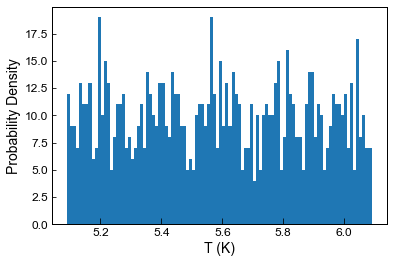

In [34]:
plt.hist(Liquids_only_noise6.loc[Liquids_only_noise6['Sample_ID_Liq_Num']==0, 'H2O_Liq'], bins=100);
plt.ylabel('Probability Density')
plt.xlabel('T (K)')